Download the sample dataset from Keras Datasets.
---
wget function directly downloads the zip file.

unzip to extract the file.

Renamed to weather.csv file for further usage.


In [38]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip -O weather.zip
!rm -rf sample_data
!unzip weather.zip
!rm weather.zip
!mv jena_climate_2009_2016.csv weather.csv

--2020-02-12 15:56:54--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c1c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘weather.zip’

weather.zip         100%[===================>]  12.94M  52.3MB/s    in 0.2s    

2020-02-12 15:56:54 (52.3 MB/s) - ‘weather.zip’ saved [13568290/13568290]

Archive:  weather.zip
  inflating: jena_climate_2009_2016.csv  


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
data = pd.read_csv("weather.csv")
#data.head()

In [0]:
temp_data = data['T (degC)']
temp_data.index = data['Date Time']

In [0]:
#Split the dataset and get mean, standard deviation, and then standardize the temperature data

split = 300000
temp_data = temp_data.values

temp_mean = temp_data[:split].mean()
temp_stdv = temp_data[:split].std()
temp_std = (temp_data - temp_mean) / temp_stdv


In [0]:
past_data = 20
target_data = 0

data = []
labels = []

start_index = 0 + past_data
end_index = split

for i in range(start_index, end_index):
  index = range(i-past_data, i)
  data.append(np.reshape(temp_std[index], (past_data, 1)))
  labels.append(temp_std[i+target_data])
x,y = np.array(data), np.array(labels)

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

Text(0.5, 0, 'Time-Step')

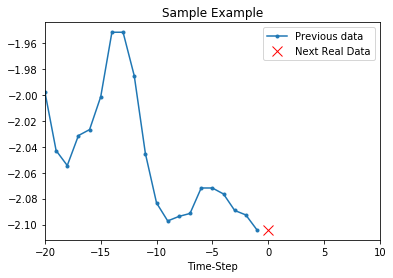

In [68]:
plot_data = [x[0],y[0]]
delta = 0
labels = ['Previous data', 'Next Real Data', 'Model Prediction']
marker = ['.-', 'rx', 'go']
time_steps = create_time_steps(plot_data[0].shape[0])
if delta:
  future = delta
else:
  future = 0

plt.title("Sample Example")

for i, xe in enumerate(plot_data):
  if i:
    plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
  else:
    plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
plt.legend()
plt.xlim([time_steps[0], (future+5)*2])
plt.xlabel('Time-Step')


In [0]:
def baseline(history):
  return np.mean(history)

In [0]:
train_univariate = tf.data.Dataset.from_tensor_slices((x, y))
train_univariate = train_univariate.cache().shuffle(256).batch(10000).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x, y))
val_univariate = val_univariate.batch(256).repeat()

lstm = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape=x.shape[-2:]), tf.keras.layers.Dense(1)])
lstm.compile(optimizer='adam', loss='mae')

In [84]:
EVALUATION_INTERVAL = 1000
EPOCHS = 10

lstm.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

Train for 1000 steps, validate for 50 steps
Epoch 1/10
1000/1000 [==============================] - 146s 146ms/step - loss: 0.0356 - val_loss: 0.0296
Epoch 2/10
1000/1000 [==============================] - 145s 145ms/step - loss: 0.0231 - val_loss: 0.0209
Epoch 3/10
1000/1000 [==============================] - 144s 144ms/step - loss: 0.0196 - val_loss: 0.0170
Epoch 4/10
1000/1000 [==============================] - 145s 145ms/step - loss: 0.0176 - val_loss: 0.0159
Epoch 5/10
1000/1000 [==============================] - 145s 145ms/step - loss: 0.0164 - val_loss: 0.0137
Epoch 6/10
1000/1000 [==============================] - 145s 145ms/step - loss: 0.0157 - val_loss: 0.0129
Epoch 7/10
1000/1000 [==============================] - 145s 145ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 8/10
1000/1000 [==============================] - 146s 146ms/step - loss: 0.0154 - val_loss: 0.0127
Epoch 9/10
1000/1000 [==============================] - 144s 144ms/step - loss: 0.0154 - val_loss: 0.0124
Ep

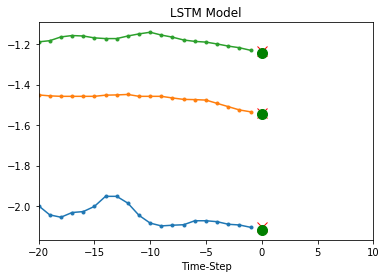

In [85]:
for xx, yy in val_univariate.take(3):
  plot_data = [xx[0].numpy(), yy[0].numpy(), lstm.predict(xx)[0]]
  delta = 0
  labels = ['Previous data', 'Next Real Data', 'Predicted value']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title("LSTM Model")
  plt.plot(time_steps, plot_data[0].flatten(), marker[0], label=labels[0])
  plt.plot(future, plot_data[1], marker[1], markersize=10, label=labels[1])
  plt.plot(future, plot_data[2], marker[2], markersize=10, label=labels[2])  
  #plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')